## **Lightcurve and transmission spectra generation using Prometheus**

#### Developed by *Rishabh Garg*

In [1]:
# Imports

from datetime import datetime
from typing import Any, Dict, List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter, MaxNLocator

import Prometheus.pythonScripts.celestialBodies as bodies
import Prometheus.pythonScripts.constants as const
import Prometheus.pythonScripts.gasProperties as gasprop
import Prometheus.pythonScripts.geometryHandler as geom

import ldtk

/home/eclipse/exoplanets/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Functions

In [ ]:
def get_exomoon_params(
    planet_name: str,
    element_name: str,
    num_particles: float,
    sigma_v: float,
    moon_radius_io: float,
    moon_orbit_planet_radii: float,
    moon_q: float,
    light_curve: bool = False,
    observed_data_phases: Optional[np.ndarray] = None,
    observed_wavelength_transmissions: Optional[np.ndarray] = None
) -> Dict[str, Any]:
    """
    Sets up parameters for a generic planet with an exomoon scenario.
    """
    planet_obj = bodies.AvailablePlanets().findPlanet(planet_name)
    # Calculate CLV parameters
    if planet_obj is None:
        raise ValueError(
            f"{planet_name} not found in AvailablePlanets.")

    params: Dict[str, Dict[str, Any]] = {
        "Fundamentals": {
            "ExomoonSource": True,
            "DopplerPlanetRotation": False,
            "CLV_variations": True,
            "RM_effect": False,
            "DopplerOrbitalMotion": True,
        },
        "Architecture": {
            "planetName": planet_name,
            "R_moon": moon_radius_io * const.R_Io,
            "a_moon": 0.49 * planet_obj.a * (planet_obj.M / (3 * planet_obj.hostStar.M))**(1/3),
            "starting_orbphase_moon": np.pi,
        },
        "Scenarios": {
            "exomoon": {"q_moon": moon_q}
        },
        "Species": {"exomoon": {element_name: {"Nparticles": num_particles, "sigma_v": sigma_v}}},
        "Grids": {
            "x_midpoint": planet_obj.a,
            "x_border": planet_obj.hostStar.R,
            "x_steps": 30,
            "phi_steps": 60,
            "rho_steps": 40,
            "upper_rho": planet_obj.hostStar.R,
            "orbphase_border": 0.025*2*np.pi,
            "orbphase_steps": 1,
        },
    }

    if light_curve:
        if observed_data_phases is not None and len(observed_data_phases) > 0:
            min_obs_phase = np.min(observed_data_phases)
            max_obs_phase = np.max(observed_data_phases)
            phase_border_fractional = max(
                abs(min_obs_phase), abs(max_obs_phase)) + 0.005
        else:
            phase_border_fractional = 0.065

        params["Grids"]["orbphase_border"] = phase_border_fractional * 2.0 * np.pi
        params["Grids"]["orbphase_steps"] = 201

    if element_name == "NaI":
        grids_Na = {
            "lower_w": 5.888e-05, "upper_w": 5.900e-05, "resolutionLow": 5e-09,
            "widthHighRes": 0.75e-8, "resolutionHigh": 2e-10,
        }
        params["Grids"].update(grids_Na)
        filters = [ldtk.BoxcarFilter(
            "a", grids_Na["lower_w"]*1e7, grids_Na["upper_w"]*1e7)]
        sc = ldtk.LDPSetCreator(
            teff=(planet_obj.hostStar.T_eff, planet_obj.hostStar.dT_eff),
            logg=(planet_obj.hostStar.log_g, planet_obj.hostStar.dlog_g),
            z=(planet_obj.hostStar.Z, planet_obj.hostStar.dZ),
            filters=filters,
        )
        ps = sc.create_profiles()
        u1, u2 = ps.coeffs_qd(do_mc=True)
        params["Architecture"]["CLV_u1"] = u1[0][0]
        params["Architecture"]["CLV_u2"] = u2[0][0]
    elif element_name == "KI":
        grids_K = {
            "lower_w": 7.660e-05, "upper_w": 7.705e-05, "resolutionLow": 5e-09,
            "widthHighRes": 1e-08, "resolutionHigh": 2e-10,
        }
        params["Grids"].update(grids_K)
    else:
        print(
            f"Warning: Element {element_name} specific grid/species params not fully set.")
        params["Grids"].update({
            "lower_w": 0.5e-4, "upper_w": 1.0e-4, "resolutionLow": 1e-8,
            "widthHighRes": 1e-8, "resolutionHigh": 1e-9
        })

    if not light_curve and observed_wavelength_transmissions is not None:
        print("Transmission mode: Overwriting wavelength grid from observed data file.")
        obs_w_cm = observed_wavelength_transmissions * 1e-8
        min_wavelength_cm = np.min(obs_w_cm)
        max_wavelength_cm = np.max(obs_w_cm)
        padding = (max_wavelength_cm - min_wavelength_cm) * 0.01
        params["Grids"]["lower_w"] = min_wavelength_cm - padding
        params["Grids"]["upper_w"] = max_wavelength_cm + padding
        print(
            f"New wavelength range (cm): {params['Grids']['lower_w']:.2e} to {params['Grids']['upper_w']:.2e}")

    return params

In [3]:
def load_observed(filepath: str) -> Tuple[Optional[np.ndarray], Optional[np.ndarray], Optional[np.ndarray]]:
    """Loads observed data from a 2 or 3 column text file."""
    try:
        data = np.loadtxt(filepath)
        if data.ndim == 1:
            if len(data) == 3:
                return np.array([data[0]]), np.array([data[1]]), np.array([data[2]])
            elif len(data) == 2:
                return np.array([data[0]]), np.array([data[1]]), np.array([0.0])
            else:
                raise ValueError(
                    f"Single row in data file {filepath} has incorrect number of columns.")

        if data.shape[1] == 3:
            return data[:, 0], data[:, 1], data[:, 2]
        elif data.shape[1] == 2:
            print(
                f"Warning: Data file {filepath} has 2 columns. Assuming zero error.")
            return data[:, 0], data[:, 1], np.zeros_like(data[:, 0])
        else:
            raise ValueError(f"Data file {filepath} must have 2 or 3 columns.")
    except Exception as e:
        print(f"Error loading observed data from {filepath}: {e}")
        return None, None, None

In [4]:
def plot_light_curve(
    orbital_phases_sim: np.ndarray,
    light_curve_values_sim: np.ndarray,
    orbital_phases_obs: Optional[np.ndarray],
    light_curve_values_obs: Optional[np.ndarray],
    light_curve_errors_obs: Optional[np.ndarray],
    element_name: str,
    planet_name: str,
    num_particles_str: str,
    sigma_v_str: str,
    filter_bandwidth_angstrom: float,
) -> None:
    plt.rcParams['font.family'] = "STIXGeneral"
    plt.rcParams['axes.labelsize'] = 14
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 12
    plt.rcParams['legend.fontsize'] = 10
    plt.rcParams['figure.titlesize'] = 16
    plt.rcParams['axes.titlesize'] = 15
    plt.rcParams['lines.linewidth'] = 2
    plt.rcParams['lines.markersize'] = 6

    fig, ax = plt.subplots(figsize=(10, 6))

    if orbital_phases_obs is not None and light_curve_values_obs is not None:
        ax.errorbar(orbital_phases_obs, light_curve_values_obs, yerr=light_curve_errors_obs, fmt='o', color='tab:blue',
                    label='Observed Data',
                    capsize=4, elinewidth=1.5, markeredgewidth=1.5, markersize=7, ecolor='dimgray', zorder=5)

    simulated_relative_flux_change = light_curve_values_sim - 1.0
    ax.plot(orbital_phases_sim, simulated_relative_flux_change, color="orangered",
            label=f"Simulated {element_name} Light Curve", zorder=10)

    title_text = (
        f"Exomoon {element_name} Light Curve for {planet_name}\n"
        f"Particles: {num_particles_str}, Filter: {filter_bandwidth_angstrom:.2f} Å"
        f", σ_v: {sigma_v_str} cm/s"
    )
    ax.set_title(title_text, fontweight='bold')
    ax.set_xlabel("Orbital Phase (𝜙)")
    ax.set_ylabel("Relative Flux Change (F/F_star - 1)")

    all_y_min: List[float] = []
    all_y_max: List[float] = []
    if light_curve_values_obs is not None and light_curve_errors_obs is not None:
        all_y_min.append(
            np.min(light_curve_values_obs - light_curve_errors_obs))
        all_y_max.append(
            np.max(light_curve_values_obs + light_curve_errors_obs))
    if len(simulated_relative_flux_change) > 0:
        all_y_min.append(np.min(simulated_relative_flux_change))
        all_y_max.append(np.max(simulated_relative_flux_change))

    if all_y_min and all_y_max:
        min_y_data, max_y_data = min(all_y_min), max(all_y_max)
        padding = 0.1 * (max_y_data - min_y_data) if (max_y_data -
                                                      min_y_data) > 1e-6 else 0.005
        ax.set_ylim(min_y_data - padding, max_y_data + padding)
    else:
        ax.set_ylim(-0.025, 0.025)

    all_x = []
    if orbital_phases_obs is not None:
        all_x.extend(orbital_phases_obs)
    if orbital_phases_sim is not None:
        all_x.extend(orbital_phases_sim)
    if all_x:
        ax.set_xlim(np.min(all_x) - 0.005, np.max(all_x) + 0.005)
    else:
        ax.set_xlim(-0.05, 0.07)

    # These values might need to be added to the celestialBodies.py CSVs
    transit_duration_hr = 2.146  # For WASP-49b
    planet_orbital_period_days = 2.78173691  # For WASP-49b
    transit_duration_days: float = transit_duration_hr / 24.0

    transit_phase_duration_half = (
        transit_duration_days / planet_orbital_period_days) / 2.0
    ax.axvline(-transit_phase_duration_half, color='k', linestyle='--', linewidth=2,
               label=f'Planet Transit Start/End (±{transit_phase_duration_half:.3f})')
    ax.axvline(transit_phase_duration_half,
               color='k', linestyle='--', linewidth=2)
    ax.axhline(0, color='black', linestyle=':', linewidth=1.5, alpha=0.7)

    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='best')

    ax.xaxis.set_major_locator(MaxNLocator(nbins=8, prune='both'))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=7))

    fig.tight_layout(pad=1.5)
    plt.show()

In [5]:
def plot_transmission_spectrum(
    wavelength_cm: np.ndarray,
    spectrum_R: np.ndarray,
    element_name: str,
    planet_name: str,
    num_particles_str: str,
    sigma_v_str: str,
    obs_wavelength: Optional[np.ndarray],
    obs_transmission: Optional[np.ndarray],
    obs_errors: Optional[np.ndarray],
) -> None:
    plt.rcParams['font.family'] = "STIXGeneral"
    plt.rcParams['axes.labelsize'] = 14
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 12

    wavelength_angstroms = wavelength_cm * 1e8
    fig, ax = plt.subplots(figsize=(12, 7))

    ax.plot(wavelength_angstroms, spectrum_R,
            linewidth=2, color="darkblue", label="Simulated Spectrum",zorder=10)

    if obs_wavelength is not None and obs_transmission is not None:
        obs_transmission = obs_transmission / 100 + 1.0
        obs_errors = obs_errors / \
            100 if obs_errors is not None else np.zeros_like(obs_transmission)
        ax.errorbar(obs_wavelength, obs_transmission, yerr=obs_errors, fmt='o', color='lightblue',
                    label='Observed Data', capsize=3, ecolor='dimgray', zorder=5, alpha=0.6)

    title_text = (
        f"Exomoon {element_name} Transmission Spectrum for {planet_name}\n"
        f"Total Particles: {num_particles_str}"
        f", σ_v: {sigma_v_str} cm/s"
    )
    ax.set_title(title_text, fontsize=16, fontweight='bold')
    ax.set_xlabel("Wavelength (Angstrom)", fontsize=14)
    # FIX: Update Y-label to be more intuitive
    ax.set_ylabel("Relative Flux", fontsize=14)

    # Auto-scaling y-axis to zoom in on the absorption features
    all_y = []
    if spectrum_R is not None:
        all_y.extend(spectrum_R)
    if obs_transmission is not None:
        all_y.extend(obs_transmission)
    if all_y:
        min_y, max_y = np.min(all_y), np.max(all_y)
        padding = (max_y - min_y) * 0.1 if (max_y - min_y) > 1e-6 else 0.005
        ax.set_ylim(min_y - padding, max_y + padding)

    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x:.4f}"))
    ax.grid(True, linestyle="--", alpha=0.7)
    ax.legend()
    fig.tight_layout()
    plt.show()

In [6]:
PLANET_NAME = input("Enter the planet name (e.g., WASP-49b): ").strip()
ELEMENT_NAME = input("Enter the species (e.g. NaI, KI): ").strip()
NUM_PARTICLES = float(input(f"Enter number of {ELEMENT_NAME} particles: "))
SIGMA_V = float(input(f"Enter {ELEMENT_NAME} sigma_v in cm/s: "))
MOON_ORBIT_PLANET_RADII = float(
    input("Enter moon orbit in planetary radii: "))
MOON_RADIUS_IO = 1.0
MOON_EXOSPHERE_Q = 3.34

Light Curve Generation

In [7]:
obs_phases, obs_flux, obs_errors = None, None, None
obs_wavelength, obs_transmission = None, None

OBSERVED_DATA_FILEPATH = input(
    "Enter path to observed light curve data: ").strip()
FILTER_BANDWIDTH_ANGSTROM = 0.75
FILTER_BANDWIDTH_CM = FILTER_BANDWIDTH_ANGSTROM * 1e-8
obs_phases, obs_flux, obs_errors = load_observed(
    OBSERVED_DATA_FILEPATH)
if obs_phases is None:
    print("Could not load observed light curve data. Continuing without it.")

In [8]:
params = get_exomoon_params(
    PLANET_NAME, ELEMENT_NAME, NUM_PARTICLES, SIGMA_V, MOON_RADIUS_IO,
    MOON_ORBIT_PLANET_RADII, MOON_EXOSPHERE_Q,
    light_curve=True, observed_data_phases=obs_phases,
    observed_wavelength_transmissions=obs_wavelength
)

fundamentalsDict = params["Fundamentals"]
scenarioDict = params["Scenarios"]
architectureDict = params["Architecture"]
speciesDict = params["Species"]
gridsDict = params["Grids"]

planet = bodies.AvailablePlanets().findPlanet(
    architectureDict["planetName"])
if fundamentalsDict["CLV_variations"]:
    planet.hostStar.addCLVparameters(
        architectureDict.get("CLV_u1", 0.0), architectureDict.get("CLV_u2", 0.0))

wavelengthGrid = gasprop.WavelengthGrid(
    gridsDict["lower_w"], gridsDict["upper_w"], gridsDict["widthHighRes"],
    gridsDict["resolutionLow"], gridsDict["resolutionHigh"])

spatialGrid = geom.Grid(
    gridsDict["x_midpoint"], gridsDict["x_border"], int(
        gridsDict["x_steps"]),
    gridsDict["upper_rho"], int(
        gridsDict["rho_steps"]), int(gridsDict["phi_steps"]),
    gridsDict["orbphase_border"], int(gridsDict["orbphase_steps"]))

In [9]:
scenarioList = []
if "exomoon" in scenarioDict:
    moon = bodies.Moon(
        architectureDict["starting_orbphase_moon"],
        architectureDict["R_moon"], architectureDict["a_moon"], planet)
    species_name = list(speciesDict["exomoon"].keys())[0]
    num_p = speciesDict["exomoon"][species_name]["Nparticles"]
    scenarioList.append(gasprop.MoonExosphere(
        num_p, scenarioDict["exomoon"]["q_moon"], moon))

In [10]:
# Check to see if the sigma_v is correctly set and that the species are available
for idx, scenario_key in enumerate(scenarioDict.keys()):
    for species_key, absorberDict in speciesDict[scenario_key].items():
        if species_key in const.AvailableSpecies().listSpeciesNames():
            if "sigma_v" in absorberDict:
                scenarioList[idx].addConstituent(
                    species_key, absorberDict["sigma_v"])
                scenarioList[idx].constituents[-1].addLookupFunctionToConstituent(
                    wavelengthGrid)
            else:
                raise ValueError(
                    f"Missing 'sigma_v' for atomic species {species_key}")
        else:  # Molecular
            raise NotImplementedError(
                "Molecular species not fully supported in this script version.")

In [11]:
atmos = gasprop.Atmosphere(
    scenarioList, fundamentalsDict["DopplerOrbitalMotion"])
main_transit_model = gasprop.Transit(atmos, wavelengthGrid, spatialGrid)
main_transit_model.addWavelength()

print("\nRunning PROMETHEUS simulation...")
start_time = datetime.now()
R_values_all_wavelengths = main_transit_model.sumOverChords()
end_time = datetime.now()
print(
    f"PROMETHEUS simulation finished. Elapsed time: {end_time - start_time}")


Running PROMETHEUS simulation...
PROMETHEUS simulation finished. Elapsed time: 0:01:39.101203


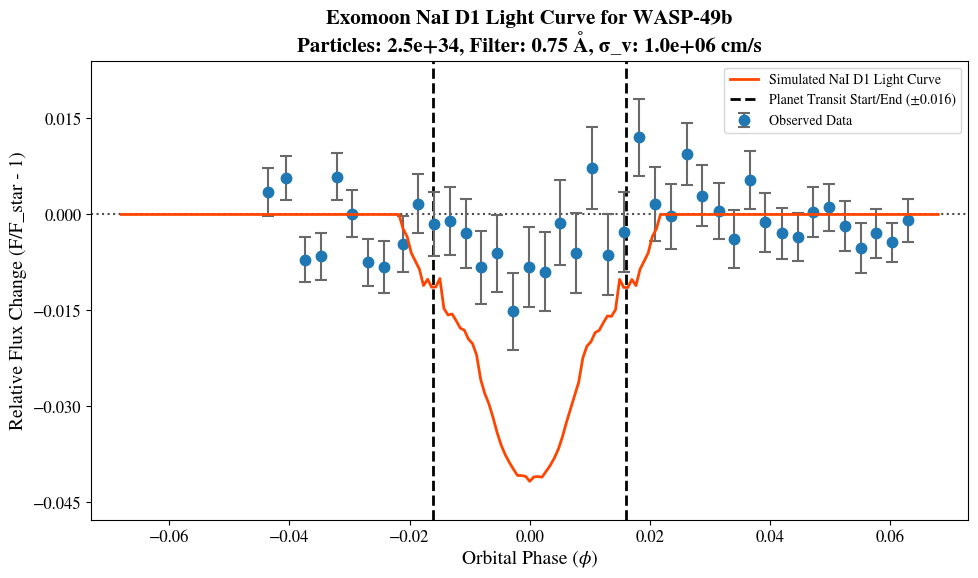

In [12]:
if R_values_all_wavelengths.ndim == 2 and R_values_all_wavelengths.shape[0] > 0:
    orbital_phases_rad = spatialGrid.constructOrbphaseAxis()
    orbital_phases_plot = orbital_phases_rad / (2.0 * np.pi)

    light_curve_sim = []
    v_los_moon = np.zeros_like(orbital_phases_rad)
    if scenarioList and hasattr(scenarioList[0], 'moon'):
        moon_obj = scenarioList[0].moon
        v_los_moon = np.array([moon_obj.getLOSvelocity(ph)
                               for ph in orbital_phases_rad])

    shifts = const.calculateDopplerShift(v_los_moon)
    NaD1_cm, NaD2_cm = 5.897558147e-5, 5.891583253e-5

    for i, R_spectrum in enumerate(R_values_all_wavelengths):
        shift_factor = shifts[i]
        shifted_D1 = NaD1_cm / shift_factor
        shifted_D2 = NaD2_cm / shift_factor
        sel1 = (main_transit_model.wavelength >= shifted_D1 - FILTER_BANDWIDTH_CM / 2) & \
               (main_transit_model.wavelength <=
                shifted_D1 + FILTER_BANDWIDTH_CM / 2)
        sel2 = (main_transit_model.wavelength >= shifted_D2 - FILTER_BANDWIDTH_CM / 2) & \
               (main_transit_model.wavelength <=
                shifted_D2 + FILTER_BANDWIDTH_CM / 2)
        if np.any(sel1 | sel2):
            light_curve_sim.append(np.mean(R_spectrum[sel1]))
        else:
            light_curve_sim.append(1.0)

    # Plot
    plot_light_curve(
        orbital_phases_plot, np.array(light_curve_sim),
        obs_phases, obs_flux, obs_errors,
        f"{ELEMENT_NAME} D1", PLANET_NAME, f"{NUM_PARTICLES:.1e}", f"{SIGMA_V:.1e}",
        FILTER_BANDWIDTH_ANGSTROM)
else:
    print("Simulation did not produce a valid light curve array.")

Transmission spectra generation

In [13]:
OBSERVED_DATA_FILEPATH = input(
    "Enter path to observed spectrum data: ").strip()
obs_wavelength, obs_transmission, obs_errors = load_observed(
    OBSERVED_DATA_FILEPATH)
if obs_wavelength is None:
    print("Could not load observed spectrum data. Continuing without it.")

In [14]:
params = get_exomoon_params(
    PLANET_NAME, ELEMENT_NAME, NUM_PARTICLES, SIGMA_V, MOON_RADIUS_IO,
    MOON_ORBIT_PLANET_RADII, MOON_EXOSPHERE_Q,
    light_curve=False, observed_data_phases=obs_phases,
    observed_wavelength_transmissions=obs_wavelength
)

fundamentalsDict = params["Fundamentals"]
scenarioDict = params["Scenarios"]
architectureDict = params["Architecture"]
speciesDict = params["Species"]
gridsDict = params["Grids"]

planet = bodies.AvailablePlanets().findPlanet(
    architectureDict["planetName"])
if fundamentalsDict["CLV_variations"]:
    planet.hostStar.addCLVparameters(
        architectureDict.get("CLV_u1", 0.0), architectureDict.get("CLV_u2", 0.0))

wavelengthGrid = gasprop.WavelengthGrid(
    gridsDict["lower_w"], gridsDict["upper_w"], gridsDict["widthHighRes"],
    gridsDict["resolutionLow"], gridsDict["resolutionHigh"])

spatialGrid = geom.Grid(
    gridsDict["x_midpoint"], gridsDict["x_border"], int(
        gridsDict["x_steps"]),
    gridsDict["upper_rho"], int(
        gridsDict["rho_steps"]), int(gridsDict["phi_steps"]),
    gridsDict["orbphase_border"], int(gridsDict["orbphase_steps"]))

Transmission mode: Overwriting wavelength grid from observed data file.
New wavelength range (cm): 5.87e-05 to 5.92e-05


In [15]:
scenarioList = []
if "exomoon" in scenarioDict:
    moon = bodies.Moon(
        architectureDict["starting_orbphase_moon"],
        architectureDict["R_moon"], architectureDict["a_moon"], planet)
    species_name = list(speciesDict["exomoon"].keys())[0]
    num_p = speciesDict["exomoon"][species_name]["Nparticles"]
    scenarioList.append(gasprop.MoonExosphere(
        num_p, scenarioDict["exomoon"]["q_moon"], moon))

In [16]:
for idx, scenario_key in enumerate(scenarioDict.keys()):
    for species_key, absorberDict in speciesDict[scenario_key].items():
        if species_key in const.AvailableSpecies().listSpeciesNames():
            if "sigma_v" in absorberDict:
                scenarioList[idx].addConstituent(
                    species_key, absorberDict["sigma_v"])
                scenarioList[idx].constituents[-1].addLookupFunctionToConstituent(
                    wavelengthGrid)
            else:
                raise ValueError(
                    f"Missing 'sigma_v' for atomic species {species_key}")
        else:  # Molecular
            raise NotImplementedError(
                "Molecular species not fully supported in this script version.")

In [17]:
atmos = gasprop.Atmosphere(
        scenarioList, fundamentalsDict["DopplerOrbitalMotion"])
main_transit_model = gasprop.Transit(atmos, wavelengthGrid, spatialGrid)
main_transit_model.addWavelength()

print("\nRunning PROMETHEUS simulation...")
start_time = datetime.now()
R_values_all_wavelengths = main_transit_model.sumOverChords()
end_time = datetime.now()
print(
    f"PROMETHEUS simulation finished. Elapsed time: {end_time - start_time}")


Running PROMETHEUS simulation...
PROMETHEUS simulation finished. Elapsed time: 0:00:00.590587


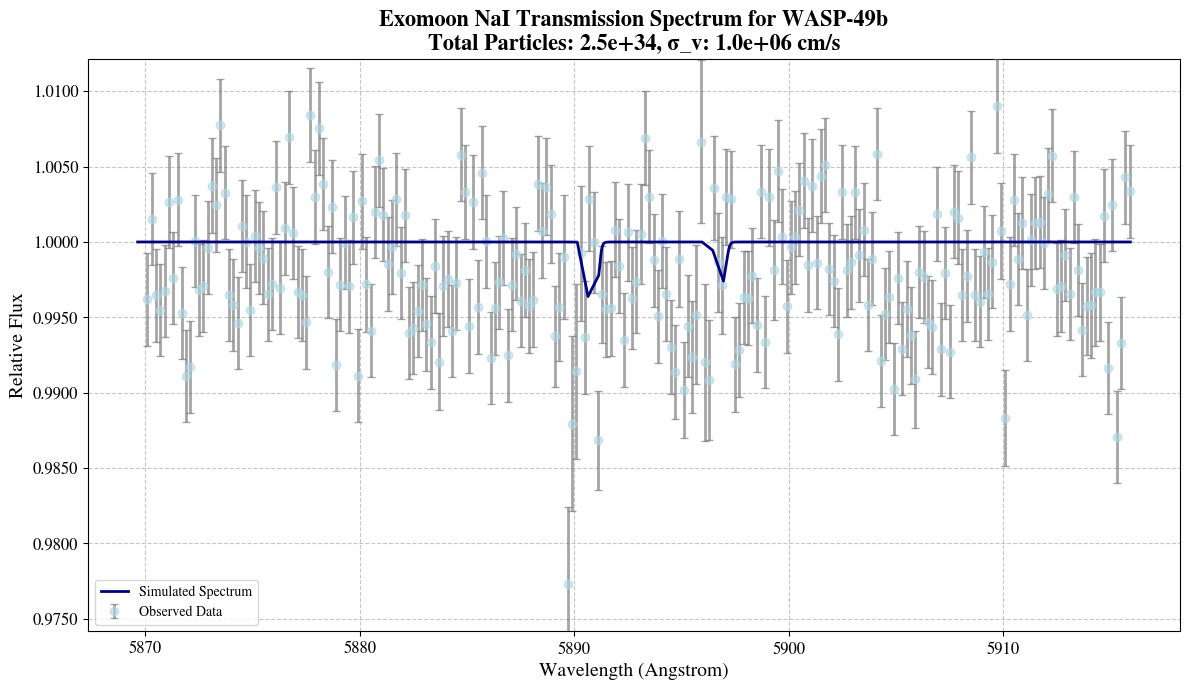

In [18]:
if R_values_all_wavelengths.ndim == 2 and R_values_all_wavelengths.shape[0] > 0:
    spectrum_to_plot = R_values_all_wavelengths[0, :].copy()
    continuum_level = np.max(spectrum_to_plot)
    spectrum_to_plot /= continuum_level

    plot_transmission_spectrum(
        main_transit_model.wavelength, spectrum_to_plot,
        ELEMENT_NAME, PLANET_NAME, f"{NUM_PARTICLES:.1e}", f"{SIGMA_V:.1e}",
        obs_wavelength, obs_transmission, obs_errors)
else:
    print("Simulation did not produce a valid spectrum array.")